# Testing CNN With Various Test Cases
## Review
At this point, we have a trained and working model that has performed literally flawlessly on our test set. When I left off, I talked a bit about how controlled my experiment was, and how I would like to test the model out on a few more variations of photos to understand our NN better via trial by fire.

A few variables I'd like to explore:
- Background pattern
- Size of head
- Position of head in frame
- Glasses
- Hairstyle (I think I have a few wigs lying around...)
- Lighting

One thing I'm thinking will make my process a bit easier is if I could take a photo directory from python through my webcam rather than what I did before: Take burst photos out of my iPhone 6S and transfer them onto my laptop after the fact. That method was just fine, but in the spirit of laziness, let's see if we can streamline that process a bit so we don't have to connect our phone to our computer and muck around with files.

## Open CV
Ah yes, let's use opencv again for this. I remember seeing [sentdex take some feed out of his webcam](https://www.youtube.com/watch?v=Jvf5y21ZqtQ). I just want to try it to take an image from my webcam if possible. I'm going to refer to this [stackoverflow answer](https://stackoverflow.com/questions/32943227/python-opencv-capture-images-from-webcam) as a baseline.

In [38]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

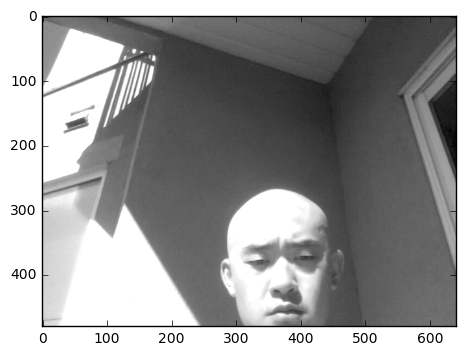

In [8]:
cam = cv2.VideoCapture(0)
s, im = cam.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im, cmap='gray')

In [9]:
im.shape

(480, 640)

Perfect. That worked. The resolution is not what we'd want though. First of all, it's rectangle. Second of all, we are looking for 91 x 91 because that's the input our CNN takes. Let's see if we can work some opencv magic to resize and format the image.

### Resizing Image To Square
Let's just first get the image down to a 480 x 480 image. What I'll do it just crop off the edges.

In [11]:
# Crop by just taking subset of 2D array
im_cropped = im[:,80:560]

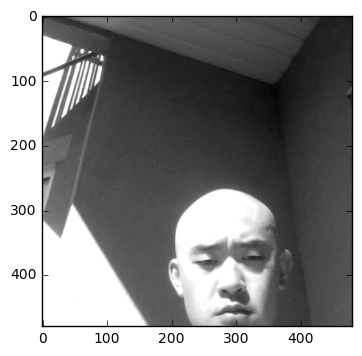

In [13]:
# Show image
plt.imshow(im_cropped, cmap='gray')

In [14]:
im_cropped.shape

(480, 480)

### Resize Image
Perfect! Now let's use opencv to resize.

In [21]:
# Resize image with opencv
im_resized = cv2.resize(im_cropped, (91, 91))

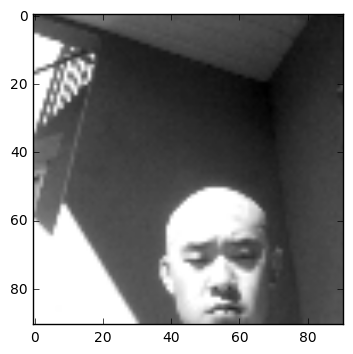

In [22]:
# Show plot
plt.imshow(im_resized, cmap='gray')

In [23]:
im_resized.shape

(91, 91)

I think we're set!

## Integrating With TFlearn Model
Okay, so now that I can directly take photos from my webcam, I can write a function that will
1. Take a photo
2. Convert to grayscale
3. Resize to 91 x 91
4. Predict using TFlearn
5. Output the photo and prediction nicely

### First Test

In [24]:
# TFlearn libraries
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [29]:
# sentdex's code to build the neural net using tflearn
#   Input layer --> conv layer w/ max pooling --> conv layer w/ max pooling --> fully connected layer --> output layer
convnet = input_data(shape = [None, 91, 91, 1], name = 'input')

convnet = conv_2d(convnet, 32, 10, activation = 'relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 10, activation = 'relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation = 'softmax')
convnet = regression(convnet, optimizer = 'sgd', learning_rate = 0.01, loss = 'categorical_crossentropy', name = 'targets')

In [30]:
# Define and load CNN
model = tflearn.DNN(convnet)
model.load('model_4_epochs_0.03_compression_99.6.tflearn')

INFO:tensorflow:Restoring parameters from /Users/chiwang/Documents/Projects/Dev/chi_lars_face_detection/notebook/model_4_epochs_0.03_compression_99.6.tflearn


The robots think this is chi


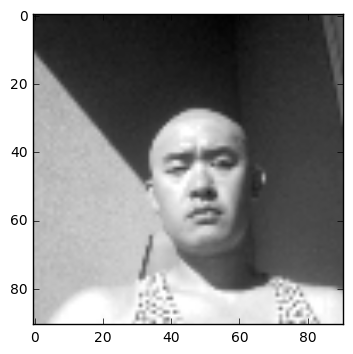

In [47]:
def take_photo_and_predict():
    # Capture image
    cam = cv2.VideoCapture(0)
    s, im = cam.read() # captures image

    # Convert to grayscale
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    # Crop & resize
    im = im[:,80:560]
    im = cv2.resize(im, (91, 91))
    
    # Format for NN input
    im_reshaped = im.reshape(-1, 91, 91, 1)
    
    # Make prediction
    y_pred = 'chi' if model.predict(im_reshaped)[0][0] > 0.5 else 'lars'
    
    # Print predictions & image
    print('The robots think this is {}'.format(y_pred))
    plt.imshow(im, cmap = 'gray')# displays captured image

take_photo_and_predict()

It got that right despite the not necessarily the same framing, head size, or background. Could it be a fluke? What happens if we take a picture of nobody at all?

### Empty Frame

The robots think this is lars


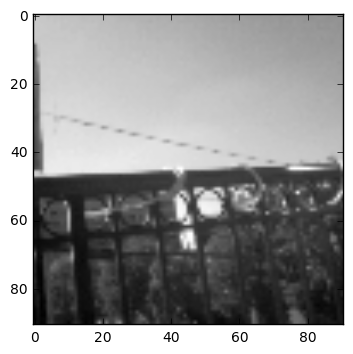

In [48]:
take_photo_and_predict()

That's an arbitrary picture off my balcony, and it thinks it's Lars. No biggie, I never trained the model to recognize the situation when there's neither of us are the photo, so it's just interesting to observe the behaviour when that situation arises. My girlfriends not home right now, but maybe I can take a photo of her face or something.

### Lars Face On Phone

The robots think this is lars


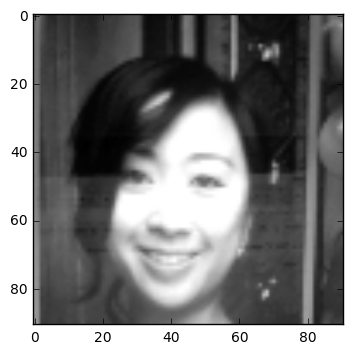

In [58]:
take_photo_and_predict()

Wow, it got this one right too. And this was just a photo of me holding a picture of my girlfriend on my phone. You can even see my finger on the right edge there. Crazy...

### Chi Indoors

The robots think this is chi


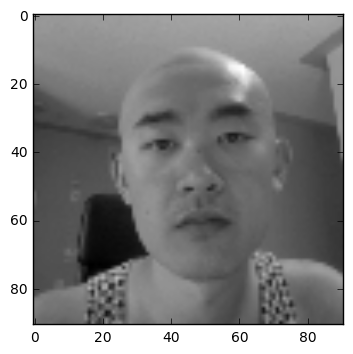

In [61]:
take_photo_and_predict()

New background, similar framing to the images we trained on... Right on!

### Nat King Cole

The robots think this is chi


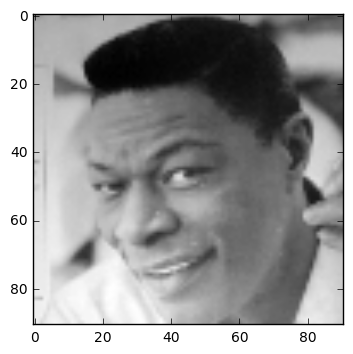

In [71]:
take_photo_and_predict()

Here, I'm trying out my good friend Nat King Cole who arose from the ashes to be a part of my horrible horrible face detection experiment. He looks like... me? So it's not necessarily the hair that's telling the difference between me and my girlfriend right now.

### Lars Indoors

The robots think this is lars


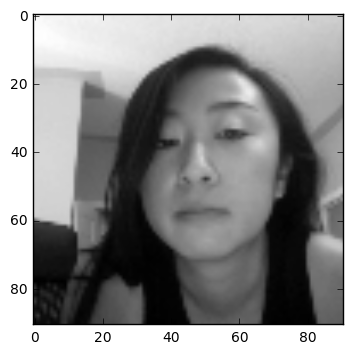

In [86]:
take_photo_and_predict()

Got it!

### Lars Indoors - Funny Face

The robots think this is lars


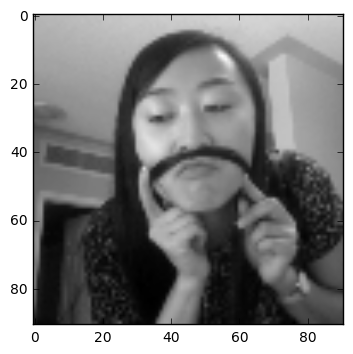

In [73]:
take_photo_and_predict()

NOT BAD...

### Empty Indoors

The robots think this is lars


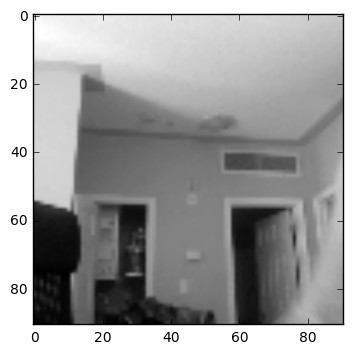

In [81]:
take_photo_and_predict()

Just want to see what kind of bias the model has towards one or the other with no subject

### Chi WIth Hat

The robots think this is lars


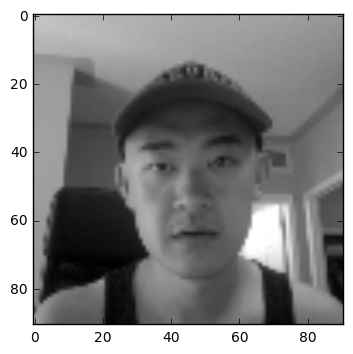

In [94]:
take_photo_and_predict()

Hmm... here we go... our first misclassification. Why? I'm not sure... My first instinct is obviously because, well, the hat, but it also thought Nat King Cole was me, and he has a full head of hair, so that's a bit confusing. I actually realize I'm not putting the percentages into the output, and that might be useful to gauge how confident the robot is in its decisions. Let's add this

In [101]:
def take_photo_and_predict():
    # Capture image
    cam = cv2.VideoCapture(0)
    s, im = cam.read() # captures image

    # Convert to grayscale
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    # Crop & resize
    im = im[:,80:560]
    im = cv2.resize(im, (91, 91))
    
    # Format for NN input
    im_reshaped = im.reshape(-1, 91, 91, 1)
    
    # Make prediction
    y_pred_proba = model.predict(im_reshaped)[0]
    y_pred = 'chi' if y_pred_proba[0] > 0.5 else 'lars'
    
    # Print predictions & image
    print('The robots think this is {} with probability {}'.format(y_pred, y_pred_proba))
    plt.imshow(im, cmap = 'gray')# displays captured image

### Lars Hair Up

The robots think this is chi with probability [ 1.  0.]


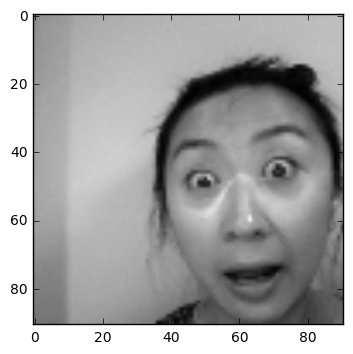

In [109]:
take_photo_and_predict()

Welp, the robots are definitely wrong about this one.

### Chi Same Position

The robots think this is chi with probability [ 1.  0.]


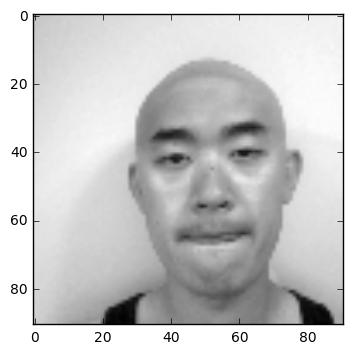

In [111]:
take_photo_and_predict()

Just wanted to calibrate to ensure that this was still working after 2 misfires haha. If the hair is the thing that's tripping up this model, let's see how dark things on the top / side of my head do.

### Chi With Headphones

The robots think this is chi with probability [ 1.  0.]


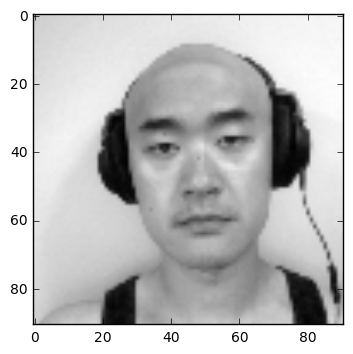

In [112]:
take_photo_and_predict()

Still working with headphones...

### Chi With Fake Hair

The robots think this is lars with probability [ 0.  1.]


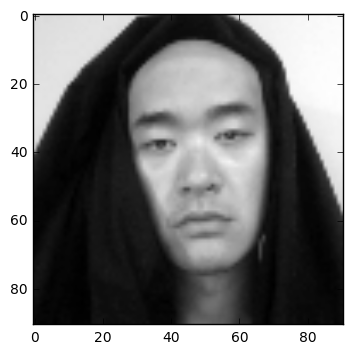

In [113]:
take_photo_and_predict()

Ok I'm convinced after this that the hair is probably a significant factor in how it's learning. Here, I draped a pair of my navy blue pants onto my head to "simulate" (if you can call it that) hair, and it thinks I'm Lars with very strong probability. In fact, I want to say that as long as the background is black, it will think that I'm Lars.

### Chi In The Dark

The robots think this is lars with probability [ 0.  1.]


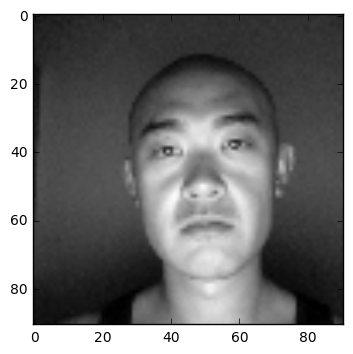

In [115]:
take_photo_and_predict()

It looks like I'm right again. Could I gather that a completely black picture will be predicted as Lars, and a completely white picture will be predicted as Chi?

### Black / Dark Image

The robots think this is chi with probability [ 0.529127    0.47087297]


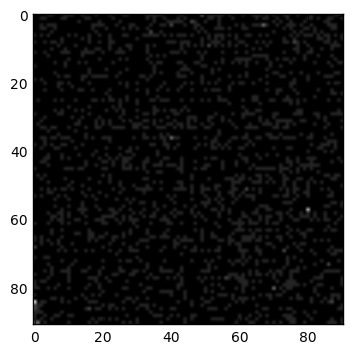

In [119]:
take_photo_and_predict()

I am incorrect... but notice the probabilities... it could've gone either way!

And...

### White / Bright Image

The robots think this is chi with probability [ 1.  0.]


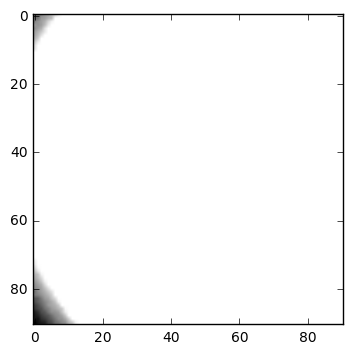

In [132]:
take_photo_and_predict()

I am incorrect here, but the results of this black / white thing is pretty inconclusive... Looks like I can't quite guess the pattern as easily as I thought I'd be able to. Perhaps the all black image is a bit too black, maybe if it was just a white ball in a black background, it would think it was a human with black hair, i.e. Lars.

### Bright Spherical Object In Darkness

The robots think this is lars with probability [ 0.  1.]


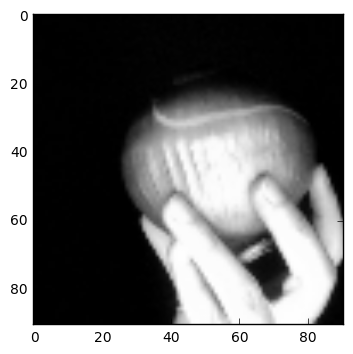

In [140]:
take_photo_and_predict()

There's me holding an onion in darkness... I'm not quite sure how the hand came into play, but it was the result I was looking for. Let's try this a bright environment.

### Bright Spherical Object In Light

The robots think this is chi with probability [ 1.  0.]


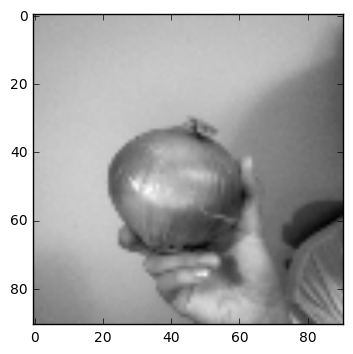

In [144]:
take_photo_and_predict()

It does think its me... interesting. You could argue that the face literally doesn't matter, and only the hair does here.

### Another Female

The robots think this is lars with probability [  3.42437367e-08   1.00000000e+00]


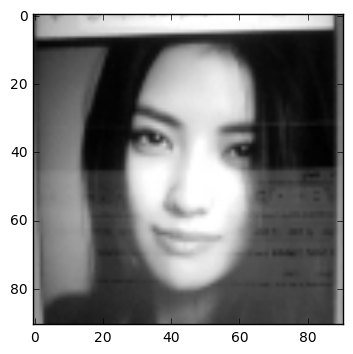

In [159]:
take_photo_and_predict()

Picture on my phone of a selected result of the google search "Asian Girl"... It's got it.

### Another Male

The robots think this is chi with probability [  9.99654531e-01   3.45461624e-04]


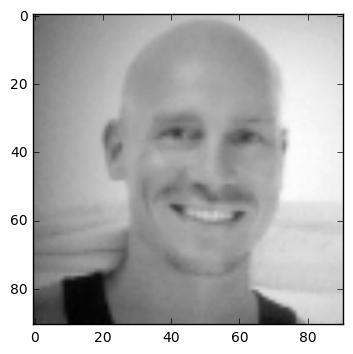

In [163]:
take_photo_and_predict()

Here, we searched "Bald Man" and it's got it again!

### Cartoon Female

The robots think this is lars with probability [ 0.  1.]


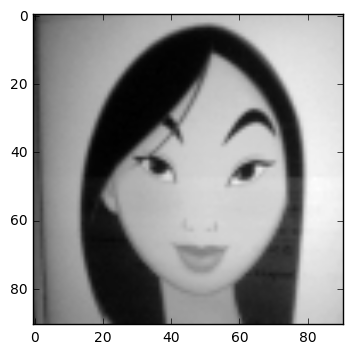

In [166]:
take_photo_and_predict()

It thinks Mulan is Larissa, which is probably the outcome we'd hope for.

### Cartoon Male

The robots think this is chi with probability [ 1.  0.]


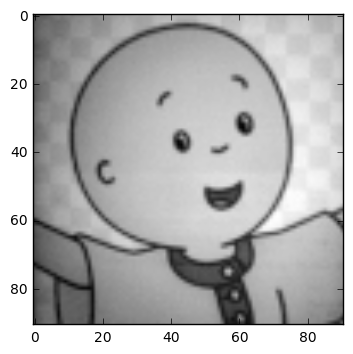

In [183]:
take_photo_and_predict()

The OG Caillou represents me, unsurprisingly. Am I happy or sad? I don't know, it's a bit bittersweet right now.

### Vin Diesel

The robots think this is chi with probability [ 1.  0.]


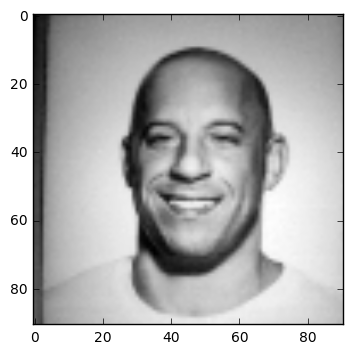

In [205]:
take_photo_and_predict()

I also get Vin Diesel as well. That's good to know. The factors I think that make a difference are hair and background color. If it generally follows this silhouette:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/47_silhouette.png" style="width: 500px;"/>

Then it will think it's Lars. Otherwise I think it will think it's me.

### Silhouette

The robots think this is lars with probability [  3.72538598e-05   9.99962687e-01]


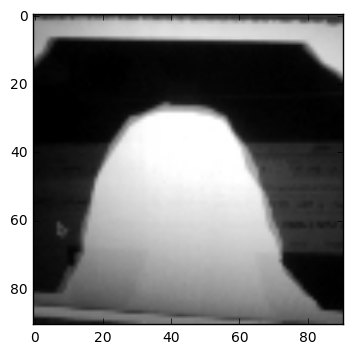

In [237]:
take_photo_and_predict()

It indeed thinks it's Larissa.

## Review
That's enough tonight man... I've draped pants over my head, I've held an onion in a dark room, I've googled "Bald Man"... yeah... that's enough.